In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline 

In [2]:
words=open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars=sorted(list(set(''.join(words))))
stoi={ch:i+1 for i,ch in enumerate(chars)}
stoi['.']=0
itos={i:ch for ch,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size=3 #context length : how many characters do we take to predict the next one?

def build_dataset(words):
    X,Y=[],[]
    
    for w in words:
        context=[0]*block_size
        for ch in w + '.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix] #crop and append
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))
Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])       

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd=10 #the dimesionality of the character embedding vectors
n_hidden=200 # the number of neurons in the hidden layer of the MLP

g=torch.Generator().manual_seed(214738647) #for reproducibility
C=torch.randn((vocab_size,n_embd),generator=g)
W1=torch.randn((n_embd*block_size,n_hidden),generator=g) #*0.2
# b1=torch.randn(n_hidden,generator=g) * 0.01
W2=torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2=torch.randn(vocab_size,generator=g) * 0

#Batchnorm parameters 
bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

parameters=[C,W1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters)) #number of parameters in total

for p in parameters:
    p.requires_grad=True

12097


In [7]:
#same optimization as last time
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix] #batch X,Y
    
    #forward pass
    emb=C[Xb] #embed the characters into vectors
    embcat=emb.view(emb.shape[0],-1) #concatenates the vectors
    #Linear layer
    hpreact=embcat @ W1 #+ b1 #hidden layer pre-activation
    #Batchnorm layer
    #-----------------------------------------------------
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=bngain*(hpreact-bnmeani)/bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running=0.99*bnmean_running + 0.001*bnmeani
        bnstd_running=0.99*bnstd_running + 0.001*bnstdi
    #-----------------------------------------------------------   
    #Non Linearity 
    h=torch.tanh(hpreact) # hidden
    logits=h @ W2 + b2  #output layer
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    
    #update
    lr= 0.1 if i<100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data+=-lr * p.grad
      
     #stats 
    if i % 10000==0: #print every once in a while
       print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
       
    lossi.append(loss.log10().item())

      0/ 200000: 3.2962
  10000/ 200000: 2.2545
  20000/ 200000: 2.3881
  30000/ 200000: 2.0409
  40000/ 200000: 2.5698
  50000/ 200000: 2.3670
  60000/ 200000: 2.2632
  70000/ 200000: 2.4280
  80000/ 200000: 2.2577
  90000/ 200000: 2.2887
 100000/ 200000: 2.4979
 110000/ 200000: 2.1811
 120000/ 200000: 1.9627
 130000/ 200000: 2.2278
 140000/ 200000: 2.0609
 150000/ 200000: 2.2790
 160000/ 200000: 2.3591
 170000/ 200000: 2.0672
 180000/ 200000: 1.8524
 190000/ 200000: 2.2579


In [8]:
#calibrate the batch norm at the end of training

with torch.no_grad():
    #pass the training set through
    emb=C[Xtr]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat @ W1 
    #measure the mean/std over the entire training set
    bnmean=hpreact.mean(0,keepdims=True)
    bnstd=hpreact.std(0,keepdims=True)
    

In [9]:
@torch.no_grad() #this decorator disables grading tracking
def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
        
    }[split]
    emb=C[x] #(N,block_size,n_embd)
    embcat=emb.view(emb.shape[0],-1) #concat into (N,block_size*n_embd)
    hpreact=embcat @ W1
    hpreact=bngain * (hpreact-bnmean_running)/bnstd_running + bnbias
    h=torch.tanh(hpreact) # (N,n_hidden)
    logits= h @ W2 + b2 # (N,vocab_size)
    loss=F.cross_entropy(logits,y)
    
split_loss('train')
split_loss('val')
    

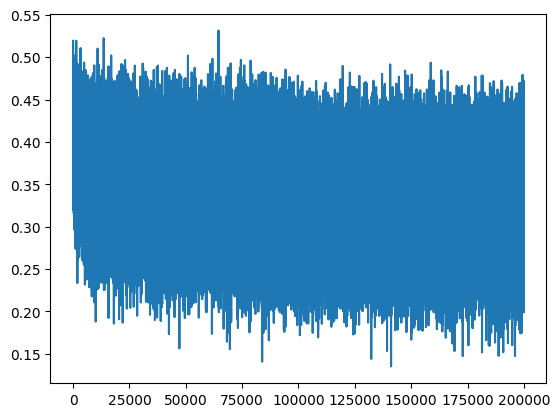

In [10]:
plt.plot(lossi)

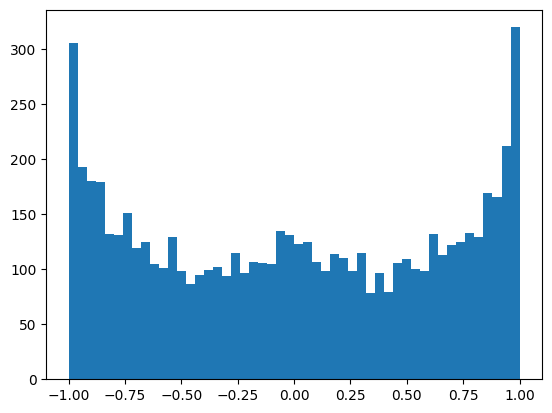

In [11]:
plt.hist(h.view(-1).tolist(),50);

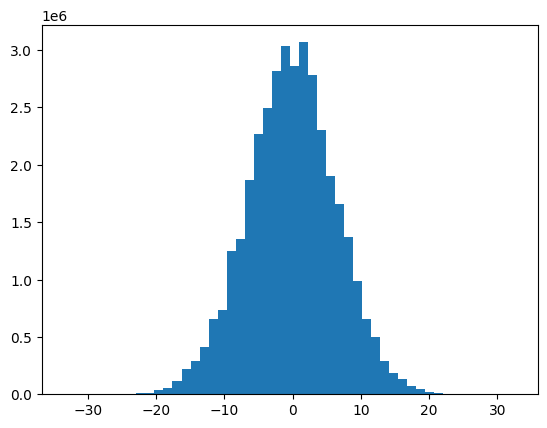

In [12]:
plt.hist(hpreact.view(-1).tolist(),50);

loss log 

original:
tanh 2.134538 val 2.168196

fix softmax confidently wrong:
train 2.07 val 2.13

fix tanh layer too saturated at init:
train 2.03559660911 val 2.1026785373

use semi-principled "kaiming init" instead of hacky init
train 2.03766417 val 2.106989862211

add batch norm layer 
train 2.0668270 val 2.1048448085

In [13]:
# SUMMARY + PYTORCHOFYING ----

In [19]:
# Let's train a deeper network
# The classes we create here are the same APIs as nn.module in Pytorch

class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5
        self.bias=torch.zeros(fan_out) if bias else None
        
    def __call__(self,x):
        self.out=x @ self.weight    
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])   
    
class BatchNorm1d:
    
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        #parameters (trained with backprop)
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)
        
    def __call__(self,x):
        #calculate the forward pass
        if self.training:
            xmean=x.mean(0,keepdims=True) #batch mean
            xvar=x.std(0,keepdims=True) #batch variance  
        else:
            xmean=self.running_mean
            xvar=self.running_var      
        xhat=(x-xmean)/torch.sqrt(xvar + self.eps)  #normalize to unit variance
        self.out=self.gamma*xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return (self.gamma,self.beta)

class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd=10 # the dimensionality of the character embedding vectors
n_hidden=100 # the number of  neurons in the hidden layer of the MLP
g=torch.Generator().manual_seed(214783647)

C=torch.randn((vocab_size,n_embd),generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layers=[
#     Linear(n_embd*block_size,n_hidden),Tanh(),
#     Linear(n_hidden,n_hidden), Tanh(),
#     Linear(n_hidden,n_hidden),Tanh(),
#     Linear(n_hidden,n_hidden),Tanh(),
#     Linear(n_hidden,n_hidden),Tanh(),
#     Linear(n_hidden,vocab_size), 
# ]      

with torch.no_grad():
    #last layer: make less confident 
    layers[-1].gamma *= 0.1
    # layers[-1].weight*=0.1
      # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight*=  1.0 #5/3
parameters=[C] + [p for layer in layers for p in layer.parameters()] 
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad=True                     
         

47024


In [38]:
max_steps=20000
batch_size=32
lossi=[]
ud=[]

for i in range(max_steps):
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix] #batch X,Y
      
    #forward pass   
    emb=C[Xb] #embed the characters into vectors
    x=emb.view(emb.shape[0],-1) #concatenate the vectors
    for layer in layers:
      x=layer(x)
    loss=F.cross_entropy(x,Yb) #loss function
    
    #backward pass 
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad=None
    loss.backward()
    
    #update 
    lr=0.1 if i<150000 else 0.01 #step learning rate decay
    for p in parameters:   
        p.data+=-lr * p.grad
        
    #track stats
    if i % 10000==0:  #print every once in a while
       print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())  
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])      
    
    # if i >= 1000:    
    #  break #AFTER_DEBUG: would take out obviously to run full optimization  

      0/  20000:2.5228
  10000/  20000:2.3977


layer 2 (      Tanh): mean +0.00, std 0.76, saturated: 20.16%
layer 5 (      Tanh): mean +0.01, std 0.83, saturated: 37.28%
layer 8 (      Tanh): mean -0.03, std 0.86, saturated: 41.53%
layer 11 (      Tanh): mean +0.01, std 0.87, saturated: 44.97%
layer 14 (      Tanh): mean +0.02, std 0.87, saturated: 43.25%


Text(0.5, 1.0, 'activation distribution')

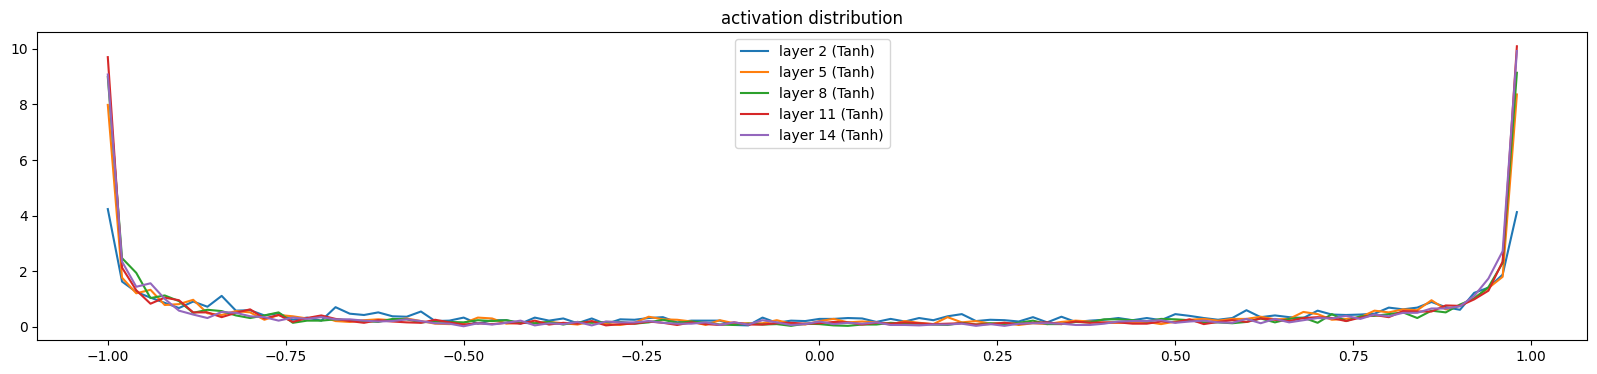

In [39]:
#visualize histograms 
plt.figure(figsize=(20,4)) #width and height of the plot
legends=[]
for i,layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer,Tanh):
        t=layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')        

layer 2 (      Tanh): mean +0.000077, std 3.096559e-03
layer 5 (      Tanh): mean -0.000008, std 2.861290e-03
layer 8 (      Tanh): mean +0.000032, std 2.698720e-03
layer 11 (      Tanh): mean -0.000013, std 2.556230e-03
layer 14 (      Tanh): mean +0.000006, std 2.936369e-03


Text(0.5, 1.0, 'gradient distribution')

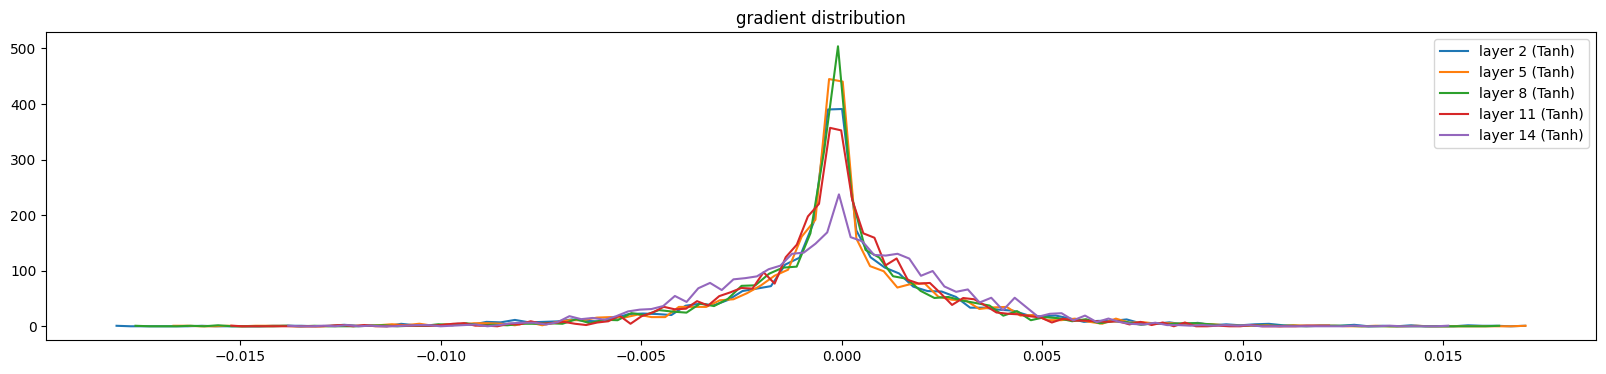

In [40]:
#visualize the histogram
plt.figure(figsize=(20,4)) #width and height of the plot
legends=[]
for i,layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer,Tanh):
        t=layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i,layer.__class__.__name__,t.mean(),t.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')           

weight   (27, 10) | mean -0.000862 | std 1.469228e-02 | grad:data ratio 1.322224e-02
weight  (30, 100) | mean +0.001390 | std 1.252151e-02 | grad:data ratio 4.874091e-02
weight (100, 100) | mean +0.000075 | std 7.896225e-03 | grad:data ratio 5.345748e-02
weight (100, 100) | mean -0.000097 | std 7.810140e-03 | grad:data ratio 5.400258e-02
weight (100, 100) | mean -0.000071 | std 7.333968e-03 | grad:data ratio 5.171588e-02
weight (100, 100) | mean -0.000095 | std 6.838025e-03 | grad:data ratio 4.913310e-02
weight  (100, 27) | mean -0.000120 | std 1.416713e-02 | grad:data ratio 7.754541e-02


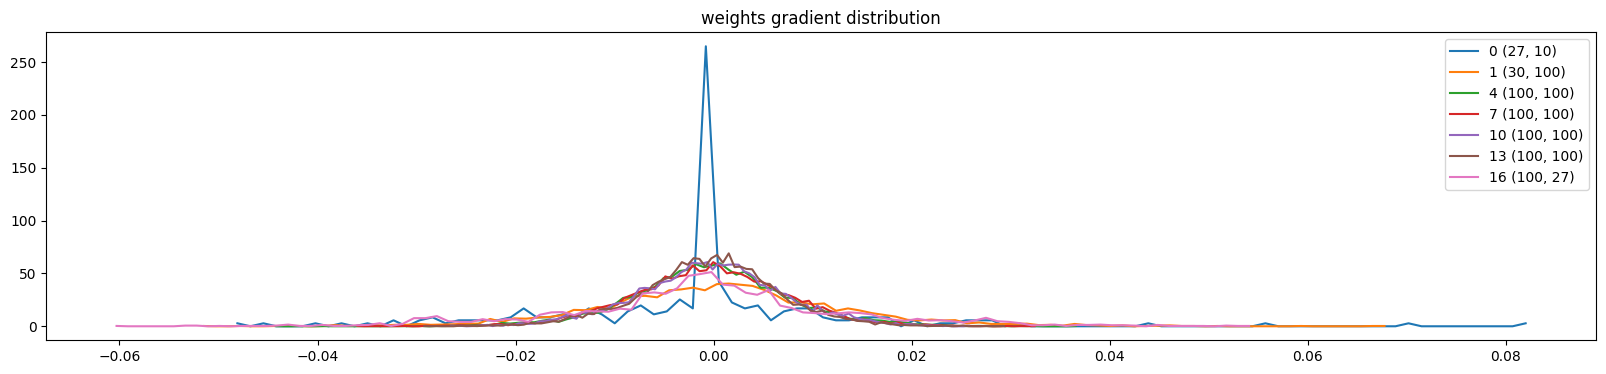

In [41]:
#visualize histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends=[]
for i,p in enumerate(parameters):
    t=p.grad
    if p.ndim==2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape),t.mean(),t.std(),t.std()/p.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');        

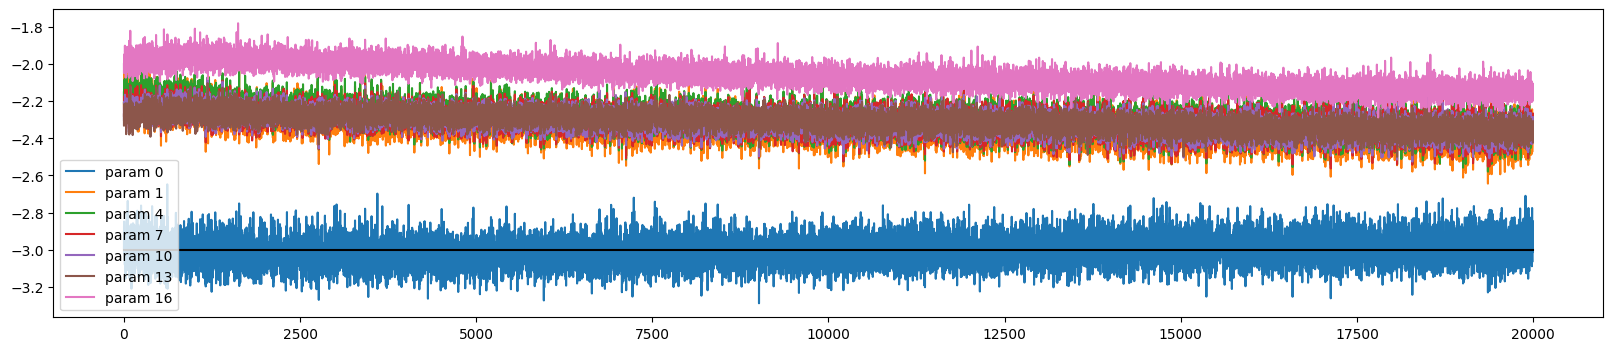

In [42]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0,len(ud)],[-3,-3],'k') #these ratios should be ~1e-3, indicate on plot
plt.legend(legends);        

In [43]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xdev,Ydev)
        
    }[split]
    emb=C[x] #(N,block_size,n_embd)
    x=emb.view(emb.shape[0],-1) # concat into (N,block_size*n_embd)
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,y)
    print(split,loss.item())

#put layers into eval mode
for layer in layers:
    layer.training=False
split_loss('train')
split_loss('test')
           

train 2.1203315258026123
test 2.154855728149414


In [44]:
#sample from the model
g=torch.Generator().manual_seed(2147483646+10)

for _ in range(20):
    out=[]
    context=[0]*block_size #initialize with all...
    while True:
        #forward pass the neural net
        emb=C[torch.tensor([context])] #(1,block_size,n_embd)
        x=emb.view(emb.shape[0],-1) #concatenate the vectors
        for layer in layers:
            x=layer(x)
        logits=x     
        probs=F.softmax(logits,dim=1)
        #sample from the distribution
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        #shift the context window and track the samples 
        context=context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token,break
        if ix==0:
            break
        
        print(''.join(itos[i] for i in out)) #decode and print the generated word

k
ke
kel
kele
kelee
n
no
nov
nove
novel
noveli
novelik
n
nw
nwk
nwke
nwkee
d
de
del
p
pa
pai
n
na
nat
nati
natiy
natiya
r
ra
ram
rami
ramii
m
ma
mar
mark
marki
markiu
markiur
markiurt
markiurte
m
ma
mar
maru
marun
k
ke
ken
g
gi
gim
gima
gimay
gimayd
gimaydj
gimaydja
gimaydjay
gimaydjayr
gimaydjayri
gimaydjayrit
gimaydjayritt
gimaydjayritte
gimaydjayritten
h
ha
har
hari
b
br
bra
bral
brale
bralek
braleki
bralekia
bralekian
bralekiann
bralekianne
b
br
bra
brar
brarz
brarze
brarzer
m
ma
mar
mari
maria
a
an
ann
anne
l
la
lak
lake
laken
lakens
n
na
nay
n
ne
nev
nevi
nevia
d
do
don
doni


In [45]:
#BatchNorm forward pass as a widget 

from ipywidgets import interact,interactive,fixed,interact_manual
import ipywidgets as widgets 
import scipy.stats as stats
import numpy as np

def normshow(x0):
    
    g=torch.Generator().manual_seed(2147483647+1)
    x=torch.randn(5,generator=g)*5
    x[0]=x0 #override the 0th example with the slider
    mu=x.mean()
    sig=x.std()
    y=(x-mu)/sig
    
    plt.figure(figsize=(10,5))
    #plot 0
    plt.plot([-6,6],[0,0],'k')
    #plot the mean and std
    xx=np.linspace(-6,6,100)
    plt.plot(xx,stats.norm.pdf(xx,mu,sig),'b')
    # plot little lines connecting input and output
    for i in range(len(x)):
     plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

    

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [46]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [47]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
